**USING RESNET-50 MODEL FOR X-RAY IMAGE CLASSIFICATION**

Unzipping training data

In [ ]:
! unzip "/content/drive/MyDrive/train.zip"

Importing necessary packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import imageio
import os
import torch
from tqdm import tqdm
import gc
import random
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Checking GPU

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(0))  # Prints the name of the first GPU
else:
    print("CUDA is not available.")

Tesla T4


Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting the training path

In [5]:
data_path = '/content/train'

Checking the X-Ray image classes in training data

In [6]:
directories = []
for directory in os.listdir(data_path):
    directories.append(directory)
print('Classes Present : ',list(directories))

Classes Present :  ['COVID', 'NORMAL', 'PNEUMONIA']


In [7]:
COVID = []
NORMAL = []
PNEUMONIA = []

for directory in directories:
    for files in os.listdir(os.path.join(data_path,directory)):
        if directory == 'COVID':
            COVID.append(os.path.join(data_path,'COVID',files))
        elif directory == 'NORMAL':
            NORMAL.append(os.path.join(data_path,'NORMAL',files))
        elif directory == 'PNEUMONIA':
            PNEUMONIA.append(os.path.join(data_path,'PNEUMONIA',files))

In [8]:
print('COVID IMAGES : ',len(COVID))
print('NORMAL IMAGES : ',len(NORMAL))
print('PNEUMONIA IMAGES : ',len(PNEUMONIA))

COVID IMAGES :  1463
NORMAL IMAGES :  1621
PNEUMONIA IMAGES :  1620


Randomly generating one image from each class

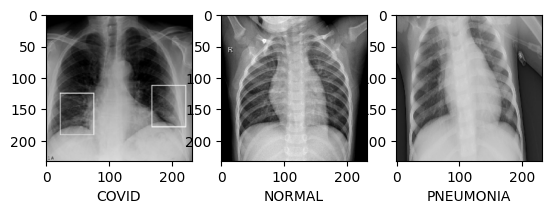

In [9]:
random_num = random.randint(0,len(COVID))
COVID_PIC = COVID[random_num]
NORMAL_PIC = NORMAL[random_num]
PNEUMONIA_PIC = PNEUMONIA[random_num]


COVID_data = imageio.imread(COVID_PIC)
NORMAL_data = imageio.imread(NORMAL_PIC)
PNEUMONIA_data = imageio.imread(PNEUMONIA_PIC)


fig,axs = plt.subplots(1,3)
axs[0].imshow(COVID_data)
axs[1].imshow(NORMAL_data)
axs[2].imshow(PNEUMONIA_data)


axs[0].set_xlabel('COVID')
axs[1].set_xlabel('NORMAL')
axs[2].set_xlabel('PNEUMONIA')

plt.show()

ImageDataGenerator for splitting data into training and validation

In [10]:
generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [11]:
train_ds = generator.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_ds = generator.flow_from_directory(
    '/content/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3764 images belonging to 3 classes.
Found 940 images belonging to 3 classes.


Checkpoint for best model storing

In [12]:
checkpoint_filepath = '/content/drive/MyDrive/checkpoints'
callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)
]

**Model Architecture**

In [13]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model_resnet.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 5s 0us/step


Training the model

Epoch 1/15
118/118 [==============================] - 32s 163ms/step - loss: 0.3509 - accuracy: 0.8889 - val_loss: 0.0930 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 2/15
118/118 [==============================] - 16s 137ms/step - loss: 0.1189 - accuracy: 0.9567 - val_loss: 0.1230 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 3/15
118/118 [==============================] - 16s 136ms/step - loss: 0.1139 - accuracy: 0.9604 - val_loss: 0.0980 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 4/15
118/118 [==============================] - 16s 137ms/step - loss: 0.1044 - accuracy: 0.9615 - val_loss: 0.0953 - val_accuracy: 0.9660 - lr: 0.0010


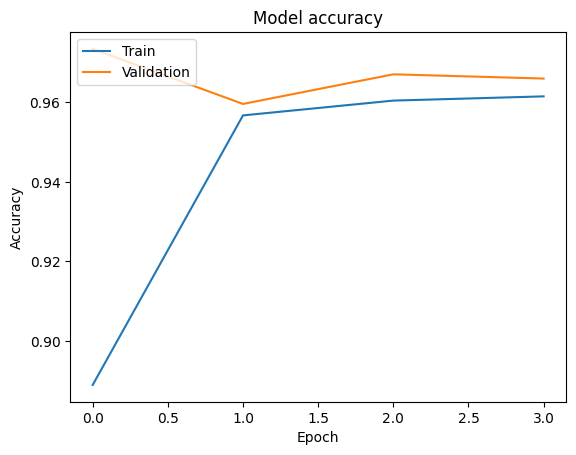

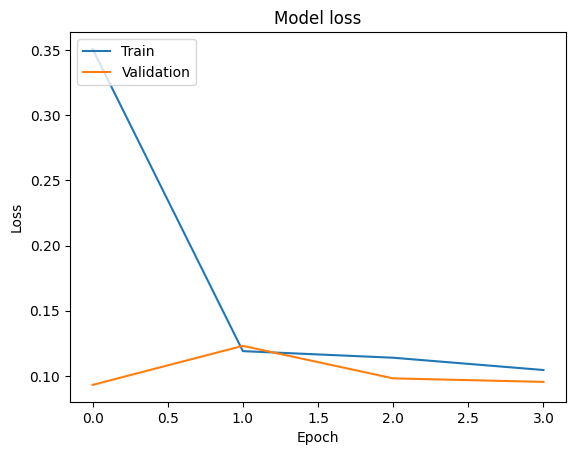

In [14]:
history = model.fit(train_ds,verbose = 1,epochs = 15,batch_size = 32,
                    validation_data = val_ds,callbacks = callback)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
#loading the best weights
model.load_weights(checkpoint_filepath)

# Printing the best training and validation accuracy
best_train_accuracy = max(history.history['accuracy'])
best_val_accuracy = max(history.history['val_accuracy'])

print(f"Best Training Accuracy: {best_train_accuracy}")
print(f"Best Validation Accuracy: {best_val_accuracy}")

Best Training Accuracy: 0.9614771604537964
Best Validation Accuracy: 0.9734042286872864


**TESTING PART**

In [ ]:
!unzip "/content/drive/MyDrive/validation.zip"

In [17]:
test_data_path = '/content/validation'

In [18]:
test_directories=[]
for directory in os.listdir(test_data_path):
    test_directories.append(directory)
print('Classes Present : ',list(test_directories))

Classes Present :  ['COVID', 'NORMAL', 'PNEUMONIA']


In [19]:
COVID_test = []
NORMAL_test = []
PNEUMONIA_test = []

for directory in test_directories:
    for files in os.listdir(os.path.join(test_data_path,directory)):
        if directory == 'COVID':
            COVID_test.append(os.path.join(test_data_path,'COVID',files))
        elif directory == 'NORMAL':
            NORMAL_test.append(os.path.join(test_data_path,'NORMAL',files))
        elif directory == 'PNEUMONIA':
            PNEUMONIA_test.append(os.path.join(test_data_path,'PNEUMONIA',files))

In [20]:
print('COVID IMAGES : ',len(COVID_test))
print('NORMAL IMAGES : ',len(NORMAL_test))
print('PNEUMONIA IMAGES : ',len(PNEUMONIA_test))

COVID IMAGES :  163
NORMAL IMAGES :  181
PNEUMONIA IMAGES :  180


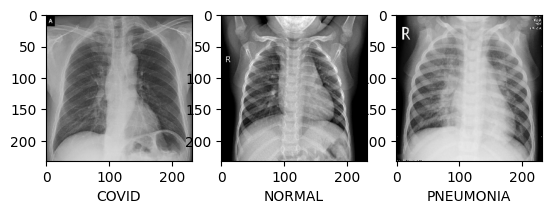

In [21]:
random_num = random.randint(0,len(COVID_test))
COVID_PIC = COVID_test[random_num]
NORMAL_PIC = NORMAL_test[random_num]
PNEUMONIA_PIC = PNEUMONIA_test[random_num]


COVID_data = imageio.imread(COVID_PIC)
NORMAL_data = imageio.imread(NORMAL_PIC)
PNEUMONIA_data = imageio.imread(PNEUMONIA_PIC)


fig,axs = plt.subplots(1,3)
axs[0].imshow(COVID_data)
axs[1].imshow(NORMAL_data)
axs[2].imshow(PNEUMONIA_data)


axs[0].set_xlabel('COVID')
axs[1].set_xlabel('NORMAL')
axs[2].set_xlabel('PNEUMONIA')

plt.show()

In [22]:
test_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.0
)

In [23]:
test_ds = test_generator.flow_from_directory(
    '/content/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 524 images belonging to 3 classes.


In [24]:
test_loss, test_accuracy = model.evaluate(
    test_ds,
    batch_size=32
)

print(f"Test accuracy: {test_accuracy}")

17/17 [==============================] - 2s 104ms/step - loss: 0.1239 - accuracy: 0.9485
Test accuracy: 0.9484732747077942


17/17 [==============================] - 2s 103ms/step - loss: 0.1411 - accuracy: 0.9370


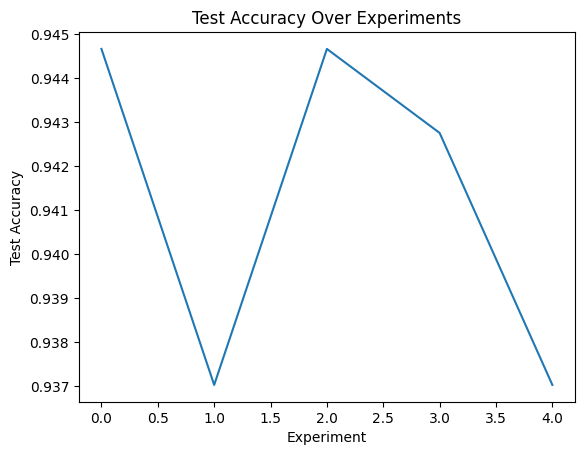

In [26]:
# Assuming you have a list of test accuracies from different runs/experiments
test_accuracies = []

# Run your evaluation code multiple times, for example, in a loop
for _ in range(5):
    test_loss, test_accuracy = model.evaluate(test_ds, batch_size=32)
    test_accuracies.append(test_accuracy)

# Plot test accuracy values
plt.plot(test_accuracies)
plt.title('Test Accuracy Over Experiments')
plt.xlabel('Experiment')
plt.ylabel('Test Accuracy')
plt.show()

**SAVING THE MODEL**

In [27]:
model.save('resnet_xray_classifier.h5')

Model Performance

In [28]:
print("Training Accuracy : ",round((best_train_accuracy),2)*100,"%  on 3764 images")
print("Validation Accuracy : ",round((best_val_accuracy),2)*100,"% on 940 images")
print("Testing Accuracy : ",round((test_accuracy),2)*100,"% on 524 images")

Training Accuracy :  96.0 %  on 3764 images
Validation Accuracy :  97.0 % on 940 images
Testing Accuracy :  94.0 % on 524 images
